In [1]:
from collections import namedtuple
from datetime import datetime, timedelta
from functools import partial
from pathlib import Path
from scipy.interpolate import interp2d
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-white')

plt.rcParams['savefig.bbox'] = 'tight'

%matplotlib inline

## Prepare the data

The data is in a bunch of `.dat` file, which are just `csv` files. Their time ordering is defined by their name, `p` indicates after B-Max, `m` means before B-Max.

In [2]:
# Load data
dfs = []
for file in os.listdir("./data"):
    if not file.endswith(".dat"):
        continue

    # Files after B-band max have a P, otherwise they have an M
    is_plus = True if file[4] == 'P' else False

    # Offset days from B-band max is encoded in the last 3 numbers of the file
    # name, and multiplied by 10
    offset = int(file[5:8]) / 10

    filepath = Path.cwd() / "data" / file
    df = pd.read_csv(
        filepath,
        delim_whitespace=True,
        skip_blank_lines=True,
        comment="#",
        header=None,
        names=("lambda", "flux", "flux_variance"),
    )

    df["days_from_max"] = offset if is_plus else -1 * offset

    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Reorder by days, then wavelength, and then re-index so the index is in order
df = df.sort_values(["days_from_max", "lambda"])
df = df.reset_index(drop=True)

del dfs  # Try to clean up some space

Linearly interpolate the data for the times when there were no observations. 

In [3]:
# Get the days and flux arrays
days = df["days_from_max"].unique()
lambdas = df["lambda"].unique()

# Create a 2D array of wavelength (X) and day (Y).
stacked = []
for day in days:
    flux = df[df["days_from_max"]==day]["flux"]
    stacked.append(flux)

# Interpolate the flux values from the wavelength and the day. Since the
# wavelengths are fixed we use a partial to bind the hard-coded wavelength
# array to the function and turn it into a function that returns the flux array
# from just the day.
flux_from_day_and_wavelength = interp2d(lambdas, days, np.stack(stacked), kind='linear')
flux_from_day = partial(flux_from_day_and_wavelength,  lambdas)

## With Blitting

You need an interable to store the artists that will be updated each frame of the plot, but it's easier to access them to update if we can get them by name. A `namedtuple` solves this problem easily.

In [4]:
Artists = namedtuple("Artists", ("flux_line", "day"))

We need a function to draw the background of the figure. It must take no arguments when called, which we will accomplish by partially applying it. It should draw everything that does not change from frame-to-frame. It also must return the artists that are to be updated for each frame. I've found it's useful to pass in the artists to the init function instead of having it generate them, as this makes it easier to define them just once.

In [5]:
def init_fig(fig, ax, artists):
    """Initialize the figure, used to draw the first frame for the animation.

    Because this function must return a list of artists to be modified in the
    animation, a list is passed in and returned without being used or altered.

    Args:
    fig (matplotlib figure): a matplotlib figure object
    ax (matplotlib axis): a matplotlib axis object
    artists: a list of artist objects

    Returns:
    list: the unaltered input artists

    """
    # Set the axis and plot titles
    ax.set_title("Supernova 2011fe Spectrum", fontsize=22)
    ax.set_xlabel("Wavelength [Å]", fontsize=20)
    ax.set_ylabel("Flux [erg s$​^{-1}$ cm$​^{-2}$ Å$​^{-1}$]", fontsize=20)

    # Set the axis range
    plt.xlim(3000, 10000)
    plt.ylim(0, 1.25e-12)

    # Set tick label size
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Pad the ticks so they do not overlap at the corner
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)

    # Must return the list of artists, but we use a pass through so that they
    # aren't created multiple times
    return artists

We also need a function to step through time and update the data. It will take no arguments and will return a "frame", which is just any Python object, but one that is consumed by `update_artists()` (below) as the sole input.

In [6]:
def step_through_frames(from_day, until_day):
    """Iterate through the days of the spectra and return flux and day
    number.

    Args:
        from_day (int): start day, measured from B-max
        until_day (int): day to stop just before, measured from B-max

    Returns:
        tuple: a tuple containing the numpy array of flux values and
        the current day of the year
    """
    # B band max happened on a specific day, and we calculate all dates from
    # then
    B_MAX_DATE = datetime.strptime("2011-09-10T12:40:10", "%Y-%m-%dT%H:%M:%S")
    for ten_day in range(from_day * 10, until_day * 10):
        day = ten_day / 10
        flux = flux_from_day(day)

        date = B_MAX_DATE + timedelta(day)

        yield (flux_from_day(day), date.strftime("%Y-%m-%d"))

Finally, we need to write a function to update all the artists with the new data from each frame.

In [7]:
def update_artists(frames, artists, lambdas):
    """Update artists with data from each frame.

    Args:
        frames (tuple): contains the flux values as a numpy array and days from
            B-Max as a float
        artists (list of Artists): a list of artists to update

    """
    flux, day = frames

    artists.flux_line.set_data(lambdas, flux)
    artists.day.set_text(day)

## Putting it all together

In [8]:
# Video metadata
VIDEO_META = {
    "title": "Supernova 2011fe Spectra Time Series",
    "artist": "Alexander Gude",
    "genre": "Scientific",
    "subject": "A spectral time series of the explosion of supernova 2011fe",
    "copyright": "CC-BY-SA 4.0",
}

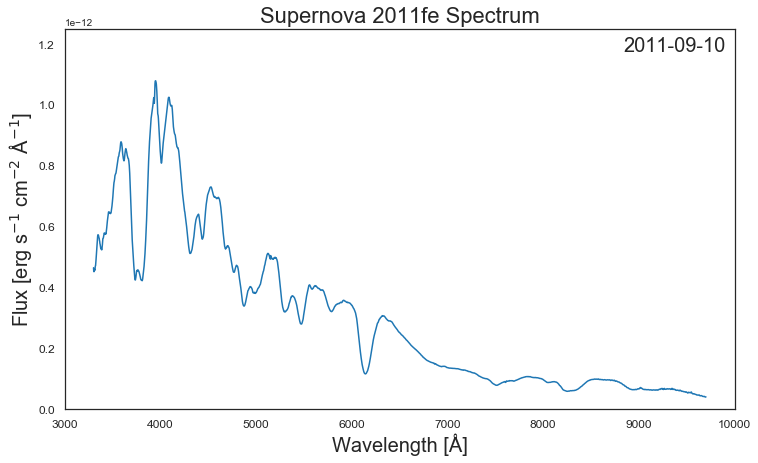

In [9]:
# Create the pot
fig, ax = plt.subplots(figsize=(12, 7))

# Set the artists
artists = Artists(
    plt.plot([], [], animated=True, label="Flux")[0],
    ax.text(0.987, 0.955, "", fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='center'),
    #ax.text(1, 1, "", fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom'),
)

# Apply the three plotting functions written above
init = partial(init_fig, fig=fig, ax=ax, artists=artists)
step = partial(step_through_frames, -15, 25)
update = partial(update_artists, artists=artists, lambdas=df["lambda"].unique())

# Generate the animation
anim = animation.FuncAnimation(
    fig=fig,
    func=update,
    frames=step,
    init_func=init,
    save_count=150, #len(list(step())),
    repeat_delay=5000,
)

# Save the animation
anim.save('/tmp/sn2011fe_spectral_time_series.mp4', fps=24, extra_args=['-vcodec', 'libx264'], dpi=300, metadata=VIDEO_META)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/sn2011fe_spectral_time_series.{ext}".format(ext=ext), bbox_inches="tight")
    
plt.show()